In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, accuracy_score, log_loss
from sklearn.model_selection import train_test_split
import matplotlib.colors
from tqdm import tqdm_notebook
import seaborn as sns
import imageio
import time
from IPython.display import HTML
from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import make_blobs

In [0]:
X, Y = make_blobs(n_samples=1000, n_features=2, centers=4, random_state=0)

In [0]:
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('', ["red", "yellow", "green"])

[]

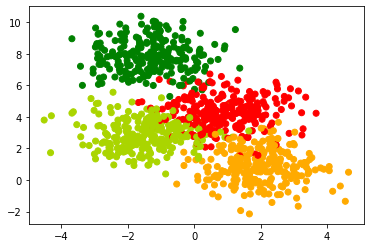

In [57]:
plt.scatter(X[:, 0], X[:, 1], cmap=my_cmap, c=Y)
plt.plot()

In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, stratify=Y, random_state=0)

In [87]:
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(750, 2) (750,) (250, 2) (250,)


In [0]:
enc = OneHotEncoder()
Y_OH_train = enc.fit_transform(np.expand_dims(Y_train, 1)).toarray()
Y_OH_test = enc.fit_transform(np.expand_dims(Y_test, 1)).toarray()

In [90]:
print(Y_OH_train.shape, type(Y_train), Y_OH_test.shape, type(Y_test))

(750, 4) <class 'numpy.ndarray'> (250, 4) <class 'numpy.ndarray'>


In [0]:
class vectorized_FFN:
  def __init__(self, W1, W2, W3):
    self.W1 = W1.copy()
    self.W2 = W2.copy()
    self.W3 = W3.copy()
    self.B1 = np.zeros((1, 2))
    self.B2 = np.zeros((1, 2))
    self.B3 = np.zeros((1, 4))
  
  def sigmoid(self, X):
    return 1/(1+np.exp(-X))
  
  def softmax(self, X):
    exps = np.exp(X)
    return exps/(np.sum(exps, 1).reshape(-1, 1))
  
  def grad_sigmoid(self, X):
    return X*(1-X)
  
  def forward_pass(self, X):

    self.A1 = np.matmul(X, self.W1) + self.B1           # (N, 2) * (2, 2) -> (N, 2)
    self.H1 = self.sigmoid(self.A1)                     # (N, 2)
    self.A2 = np.matmul(self.H1, self.W2) + self.B2     # (N, 2) * (2, 2) -> (N, 2)
    self.H2 = self.sigmoid(self.A2)                     # (N, 2)
    self.A3 = np.matmul(self.H2, self.W3) + self.B3     # (N, 2) * (2, 4) -> (N, 4)
    self.H3 = self.softmax(self.A3)                     # (N, 4)
    return self.H3

  def grad(self, X, Y):
    self.forward_pass(X)

    self.dA3 = self.H3 - Y                        # (N, 4)
    self.dW3 = np.matmul(self.H2.T, self.dA3)     # (2, N) * (N, 4) -> (2, 4)
    self.dB3 = np.sum(self.dA3, 0).reshape(1, -1) # (1, 4)

    self.dH2 = np.matmul(self.dA3, self.W3.T)         # (N, 4) * (4, 2) -> (N, 2)
    self.dA2 = np.multiply(self.dH2, self.grad_sigmoid(self.H2))            # (N, 4)
    self.dW2 = np.matmul(self.H1.T, self.dA2)           # (2, N) * (N, 4) -> (2, 4)
    self.dB2 = np.sum(self.dA2, 0).reshape(1, -1)       # (1, 4)

    self.dH1 = np.matmul(self.dA2, self.W2.T)             # (N, 4) * (4, 2) -> (N, 2)
    self.dA1 = np.multiply(self.dH1, self.grad_sigmoid(self.H1))      # (N, 2)
    self.dW1 = np.matmul(X.T, self.dA1)                           # (2, N) * (N, 2) -> (2, 2)
    self.dB1 = np.sum(self.dA1, 0).reshape(1, -1)                                  # (1, 2)

  def fit(self, X, Y, epochs=10, lr = 0.1):
    loss = {}
    for epoch in tqdm_notebook(range(epochs), total = epochs, unit = 'epoch'):
      self.grad(X, Y)
      m = X.shape[0]

      self.W1 -= lr * self.dW1/m
      self.W2 -= lr * self.dW2/m
      self.B1 -= lr * self.dB1/m
      self.B2 -= lr * self.dB2/m
      self.W3 -= lr * self.dW3/m
      self.B3 -= lr * self.dB3/m

      Y_pred = self.predict(X)
      loss[epoch] = log_loss(np.argmax(Y, 1), Y_pred)
    
    plt.plot(list(loss.values()))
    plt.xlabel('Epochs')
    plt.ylabel('Error')
    plt.show
  
  def predict(self, X):
    Y_pred = self.forward_pass(X)
    return np.array(Y_pred).squeeze()

In [127]:
w1 = np.random.randn(2, 2)
w2 = np.random.randn(2, 2)
w3 = np.random.randn(2, 4)
print(w1, w2, w3)

[[ 0.69058657  1.29056891]
 [ 1.16467012 -0.43824414]] [[ 0.09741967 -1.27288396]
 [ 0.5071898  -1.44184159]] [[ 0.82824443  1.56819024  0.90504126 -1.01018389]
 [ 0.43803202 -0.69781636  0.43499975 -1.44719957]]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


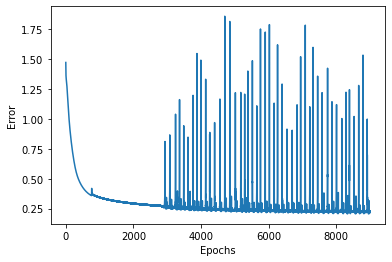

In [130]:
v_ffn = vectorized_FFN(w1, w2, w3)
v_ffn.fit(X_train, Y_OH_train, epochs = 9000, lr=0.5)

In [131]:
Y_pred_train = v_ffn.predict(X_train)
Y_pred_train = np.argmax(Y_pred_train, 1)
print(accuracy_score(Y_train, Y_pred_train))

0.9213333333333333


In [132]:
Y_pred_test = v_ffn.predict(X_test)
Y_pred_test = np.argmax(Y_pred_test, 1)
print(accuracy_score(Y_test, Y_pred_test))

0.92


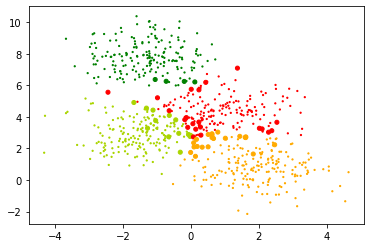

In [133]:
plt.scatter(X_train[:,0], X_train[:,1], c=Y_pred_train, cmap=my_cmap, s=15*(np.abs(np.sign(Y_pred_train-Y_train))+.1))
plt.show()